Training, Validation, and Testing
=====================================

In this Jupyter Notebook...

* Develop model for predicting diffusion activation energy of a solute element moving through another host element using DFT-calculated element descriptors 

* Use K-fold cross validation for developing the model and finding the error in the fitted model


Import necessary modules

In [1]:
import numpy as np
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import pandas as pd 
import sklearn as sk
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

Load the data from: https://figshare.com/articles/dataset/MAST-ML_Education_Datasets/7017254/5

This dataset was originally published here: https://www.nature.com/articles/sdata201654#MOESM165 where they describe how the data was generated [1].

Various machine learning methods implemented on this dataset here: https://www.sciencedirect.com/science/article/pii/S0927025617301738#bi005 [2]

1. Wu, H., Mayeshiba, T., & Morgan, D. (2016). High-throughput ab-initio dilute solute diffusion database. *Scientific data*, 3(1), 1-11.
2. Wu, H., Lorenson, A., Anderson, B., Witteman, L., Wu, H., Meredig, B., & Morgan, D. (2017). Robust FCC solute diffusion predictions from ab-initio machine learning methods. *Computational Materials Science*, 134, 160-165.

We will be using this dataset to develop a model to predict the diffusion activation energy of various dilute solute diffusion systems using physical properties/descriptors of the involved elements. The activation energies in this dataset were calculated through density functional theory (DFT) calculations and showed good agreement with experimental solute diffusion data. All data has been normalized.


In [2]:
data = pd.read_csv("data/solute_diffusion.csv", "rb", delimiter=",")
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')
data.head(5)

There are 408 rows and 29 columns


,Material compositions 1,Material compositions 2,Enorm (eV),E_raw (eV),Site2_MeltingT,Site1_MendeleevNumber,Site1_MiracleRadius,GSestFCClatcnt_max_value,Site2_BCCenergy_pa,Site1_BCCfermi,...,BCCenergy_pa_composition_average,MiracleRadius_min_value,MeltingT_min_value,NUnfilled_max_value,Site2_Group,Site1_CovalentRadii,Site2_NUnfilled,SpecificHeatCapacity_difference,Site1_Electronegativity,BCCenergy_pa_arithmetic_average
0,Ag,Ag,0.000000,1.824450,-0.531814,0.402504,0.263045,-0.626925,1.021337,-1.217816,...,1.386573,0.859808,-0.046109,-1.546561,0.626615,0.690287,-1.036320,-1.057898,0.099471,1.386573
1,Ag,Co,-0.090142,1.734308,0.064051,0.402504,0.263045,-0.626925,-0.248457,-1.217816,...,0.484851,-0.730180,-0.046109,-0.801582,0.116318,0.690287,-0.391288,-0.388610,0.099471,0.484851
2,Ag,Cr,0.259139,2.083589,0.524584,0.402504,0.263045,-0.626925,-1.000991,-1.217816,...,-0.049547,-0.311762,-0.046109,0.315885,-0.649128,0.690287,0.576260,-0.287857,0.099471,-0.049547
3,Ag,Cu,-0.022200,1.802250,-0.394504,0.402504,0.263045,-0.626925,0.746249,-1.217816,...,1.191224,-0.646497,-0.046109,-1.546561,0.626615,0.690287,-1.036320,-0.518150,0.099471,1.191224
4,Ag,Fe,0.317672,2.142122,0.112116,0.402504,0.263045,-0.626925,-0.637552,-1.217816,...,0.208542,-0.730180,-0.046109,-0.429093,-0.138831,0.690287,-0.068772,-0.287857,0.099471,0.208542


The data set contains 408 different host-solute pairs. Material compositions 1 (Column 0) refers to the host element, while Material compositions 2 (Column 1) is the solute element. 

Columns 4 and up are various properties of thes elements. Supplementary Data 1 of this paper [https://www.sciencedirect.com/science/article/pii/S0927025617301738#bi005] describe these descriptors. 

Columns 2 and 3 are the DFT calculated activation energies, E_norm being the normalized activation energy and E_raw being the raw calculation. That is, Al-Al could have an absolute value of 0.5 eV, but this value is subtracted off to bring the value in the dataset to 0 eV. Then every datapoint with Al as the host has the same adjustment made to it. If Al-Ag's absolute value is 0.7 eV, the reported value in the dataset is 0.2 eV (0.7 - 0.5). 

Data Visualization
-----------------------

<AxesSubplot:xlabel='Site2_Group', ylabel='Enorm (eV)'>

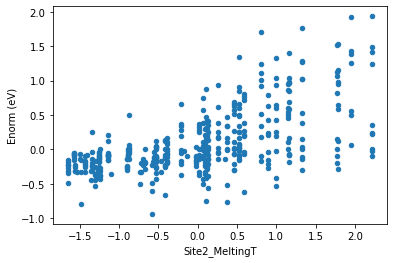

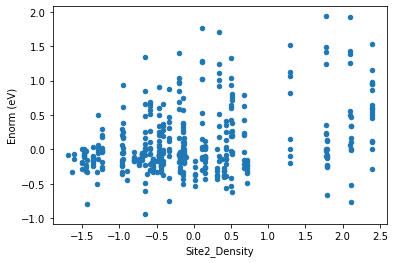

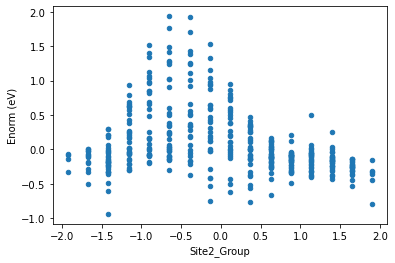

In [3]:
data.plot.scatter(x="Site2_MeltingT", y="Enorm (eV)")
data.plot.scatter(x="Site2_Density", y="Enorm (eV)")
data.plot.scatter(x="Site2_Group", y="Enorm (eV)")

K-fold cross validation
-----------------------------
We will be developing a linear regression model for this dataset. K-fold cross validation will be employed to determine the error in our model.

Here, we will be using the sklearn functions KFold to separate are training and testing datasets.

KFold 1 / 4
TRAIN: [ 0  1  3  5  6  7  9 10 11 12 13 15 16 17 20 21 22 23 25 26 27 28 29 30
 31 32 33 34 35 38 39 41 42 43 45 46 47 48 49 50 52 53 54 55 57 58 59 60
 61 62 63 64 65 68 69 70 71 74 75 76 77 78 79 80 85 86 87 88 91 94 95 96
 97 98 99]
TEST: [ 2  4  8 14 18 19 24 36 37 40 44 51 56 66 67 72 73 81 82 83 84 89 90 92
 93] 

KFold 2 / 4
TRAIN: [ 0  2  4  5  6  7  8  9 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26 28
 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45 46 49 51 54 56 58 59 61 63
 64 66 67 69 71 72 73 74 75 76 77 78 79 81 82 83 84 85 86 89 90 91 92 93
 96 98 99]
TEST: [ 1  3 10 12 27 29 41 47 48 50 52 53 55 57 60 62 65 68 70 80 87 88 94 95
 97] 

KFold 3 / 4
TRAIN: [ 1  2  3  4  5  8 10 11 12 13 14 16 18 19 22 23 24 27 28 29 32 33 35 36
 37 39 40 41 42 44 45 46 47 48 50 51 52 53 54 55 56 57 60 61 62 63 65 66
 67 68 69 70 72 73 76 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 97 98 99]
TEST: [ 0  6  7  9 15 17 20 21 25 26 30 31 34 38 43 49 58 59 64 71 74 75 77 78
 9

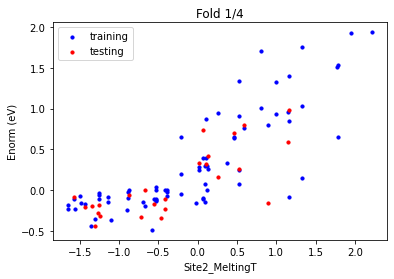

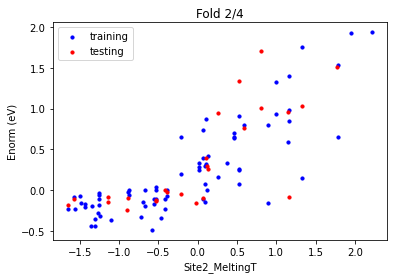

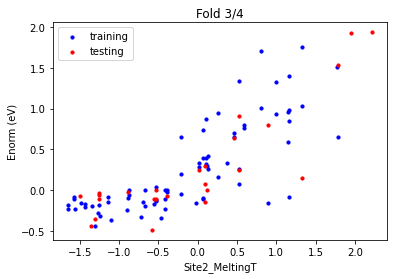

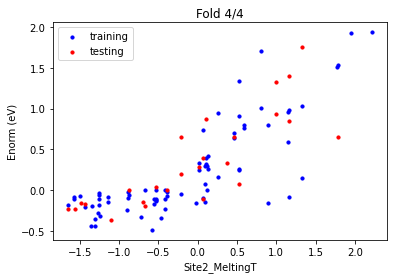

In [4]:
K=4 # Define number of folds, K 
kf = KFold(n_splits=K, random_state=52, shuffle=True) # KFold will split our data into training and validation sets, 
                                                      # where "n_splits" defines the number of folds and the Boolean 
                                                      # "shuffle" will randomize the folds.
i=1
for train_index, test_index in kf.split(data.iloc[0:100,:]):
    print('KFold', i, '/',K)
    print("TRAIN:", train_index) 
    print("TEST:", test_index, "\n")
    x_train= data.iloc[train_index,4:].to_numpy()  # Set training data used to develop model.
    y_train= data.iloc[train_index,2].to_numpy()  # y_train is the activation energy.
    x_test= data.iloc[test_index, 4:].to_numpy()
    y_test= data.iloc[test_index,2].to_numpy()
    plt.figure()
    plt.scatter(x_train[:,0],y_train,10,'blue',label='training')  #Visualizing Column 0, the first independent variable, melting temp of the solute
    plt.scatter(x_test[:,0],y_test,10,'red',label='testing')
    plt.xlabel('Site2_MeltingT')
    plt.ylabel('Enorm (eV)')
    plt.title('Fold {0}/{1}'.format(i,K))
    plt.legend()
    plt.show
    i+=1

/Users/ajspakow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


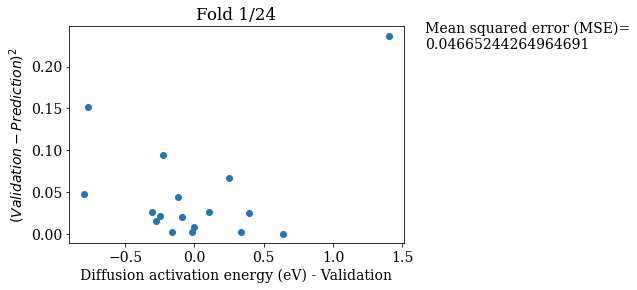

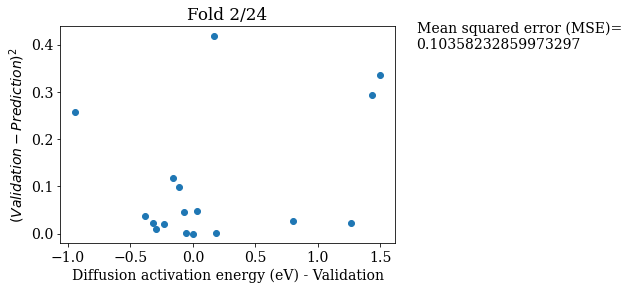

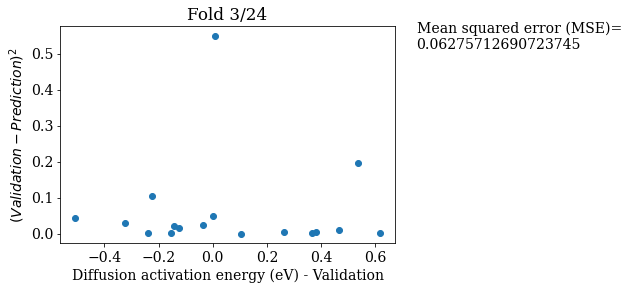

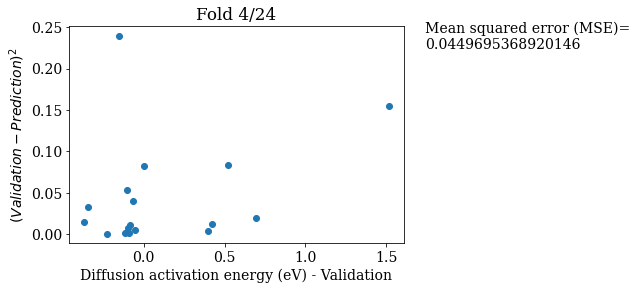

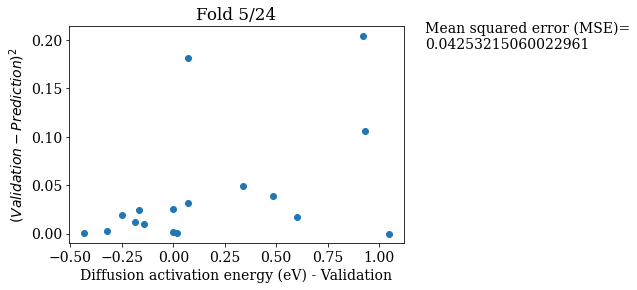

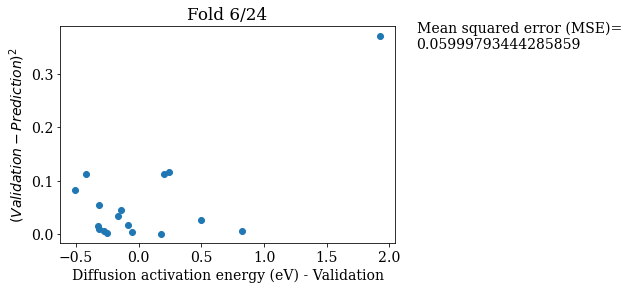

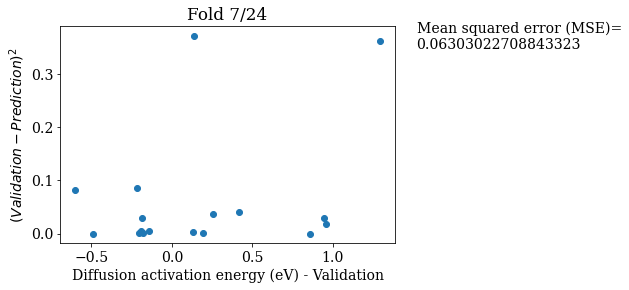

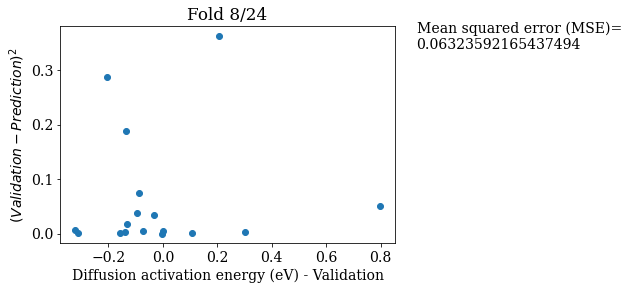

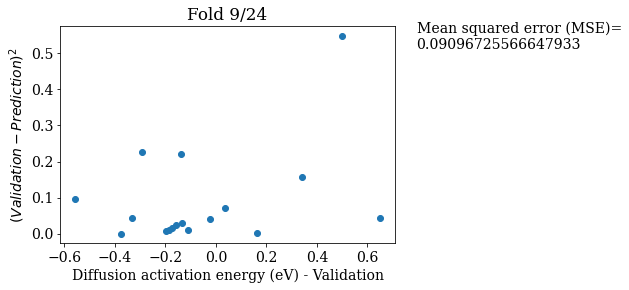

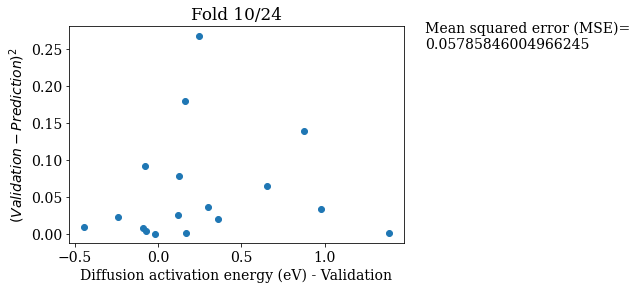

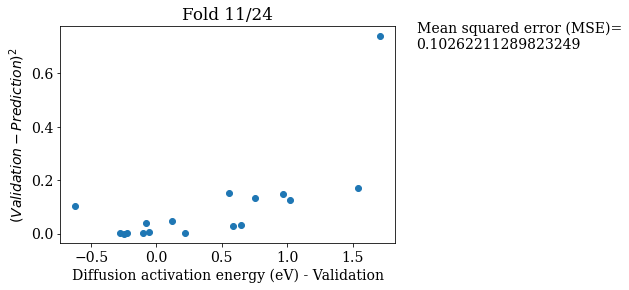

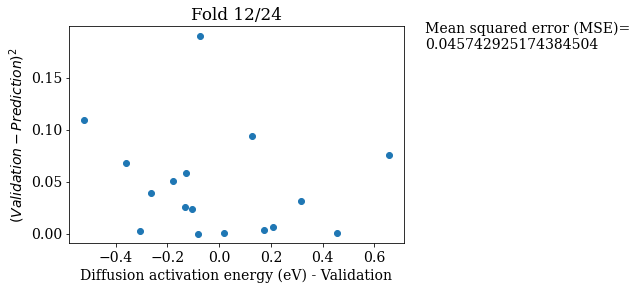

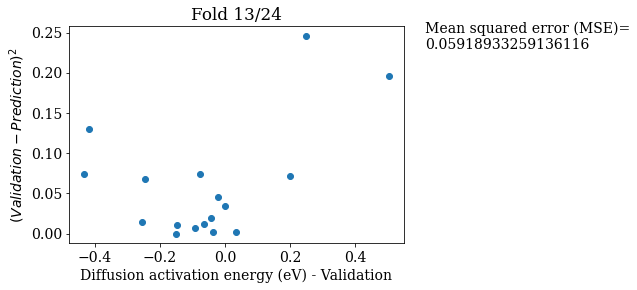

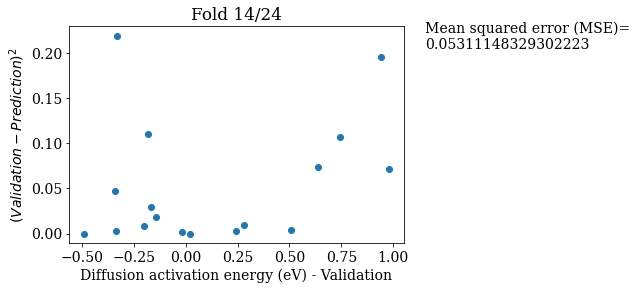

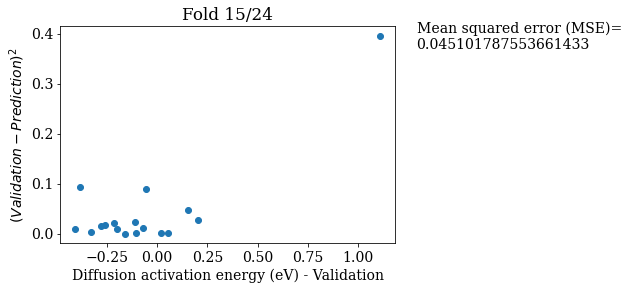

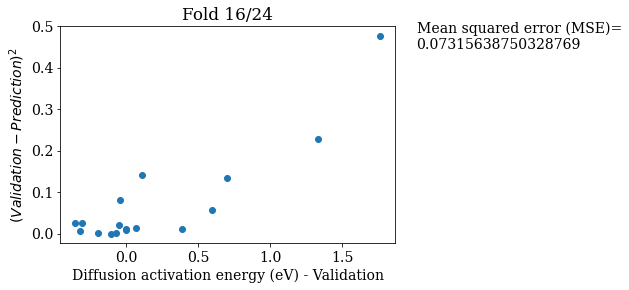

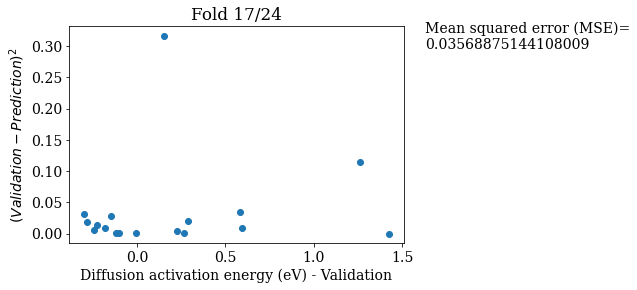

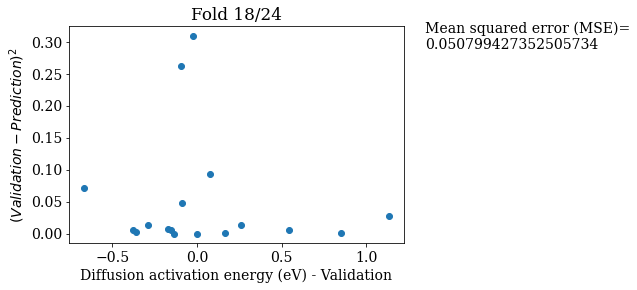

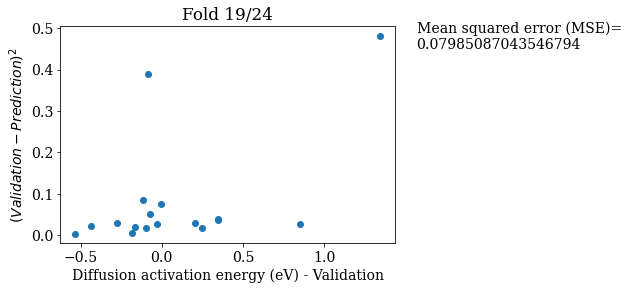

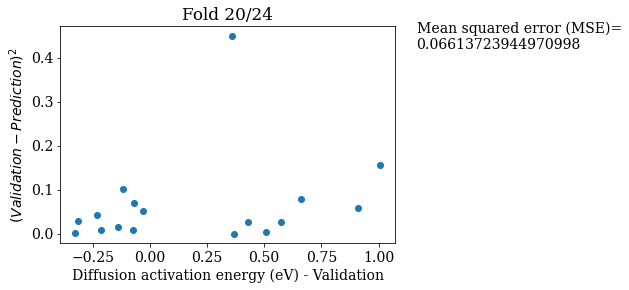

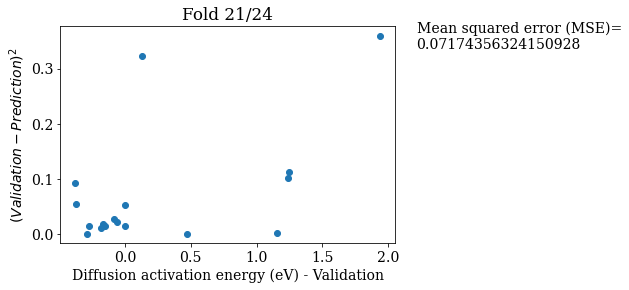

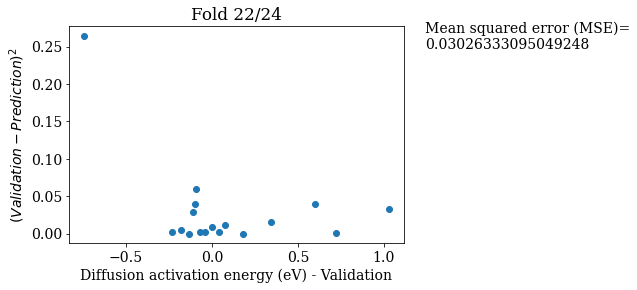

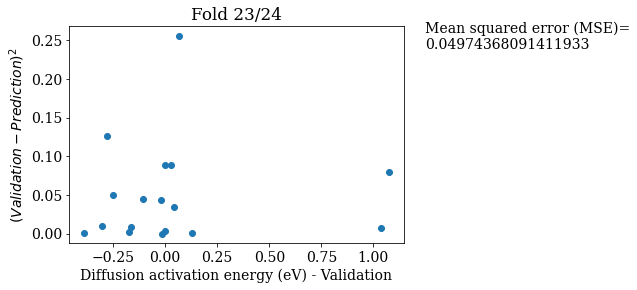

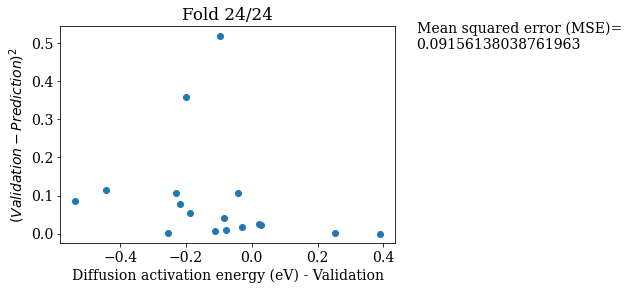

In [5]:
K=24   # Define number of folds
kf = KFold(n_splits=K, random_state=12, shuffle=True) # KFold will split our data into training and validation sets, 
                                                      # where "n_splits" defines the number of folds and the Boolean 
                                                      # "shuffle" will randomize the folds.
all_MSE=[]
i=1
for train_index, test_index in kf.split(data):
    x_train= data.iloc[train_index,4:].to_numpy()     # Set training data. x_train is material descriptors in dataset (columns 4+)
    y_train= data.iloc[train_index,2].to_numpy()      # y_train is the activation energy (column 2)
    x_test= data.iloc[test_index, 4:].to_numpy()
    y_test= data.iloc[test_index,2].to_numpy()     
    model = LinearRegression().fit(x_train, y_train)  # sklearn function for linear regression model
    y_fit= model.predict(x_test)                      # Model prediction
    squared_error= (y_test-y_fit)**2
    mse=np.average(squared_error)             # SSF calculation: Mean squared error for each fold
    all_MSE=np.append(all_MSE,mse)
    plt.figure()
    font = {'family' : 'serif',
        'weight':'normal',
        'size': 14}
    plt.rc('font', **font)
    plt.plot(y_test, squared_error, 'o')
    plt.xlabel('Diffusion activation energy (eV) - Validation')
    plt.ylabel('$(Validation-Prediction)^{2}$')
    plt.title('Fold {0}/{1}'.format(i,K))
    plt.figtext(0.95, 0.8, 'Mean squared error (MSE)'+'=\n{0}'.format(mse))
    plt.show
    i+=1


Here we see the percent error of the prediction from the model developed cycling through each training/testing fold.   

Cross Validation Error
-----------------------------
At each fold, we calculate the average squared difference between the predicted value and the validation value (see previous cell). We then find the average amongst all folds. This is the cross validation error and predicts the error of the model fit.

In [6]:
SSF= 1/K * np.sum(all_MSE)
print('Average MSE across folds/SSF_CV:', SSF)

Average MSE across folds/SSF_CV: 0.0620956524057135


Model Fit
-------------
This cross validation error estimates the error of the fitted model. This fitted model is generated using the complete set of data.

Text(0, 0.5, 'Actual diffusion activation energy')

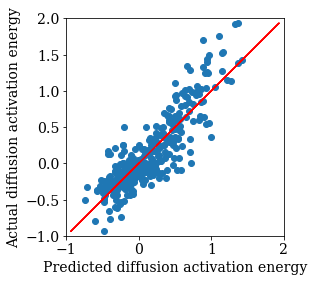

In [7]:
x_data=data.iloc[:, 4:].to_numpy()  # Set all data as training and testing data
y_data=data.iloc[:, 2].to_numpy()
linear_reg = LinearRegression().fit(x_data, y_data)  # Linear regression using all data
y_model_prediction= linear_reg.predict(x_data)      # Fitted Model Prediction
plt.plot(y_model_prediction,y_data, 'o', y_data, y_data, 'r-') # Plotting training data vs model prediction
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1,2)
plt.ylim(-1,2)
plt.xlabel('Predicted diffusion activation energy')
plt.ylabel('Actual diffusion activation energy')


Plot of prediction vs actual diffusion activation energy. Red line is y=x, i.e. if prediction is same as actual

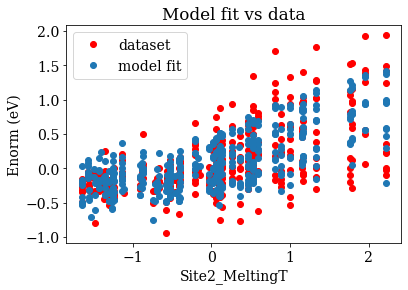

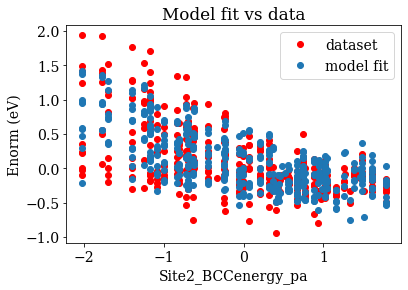

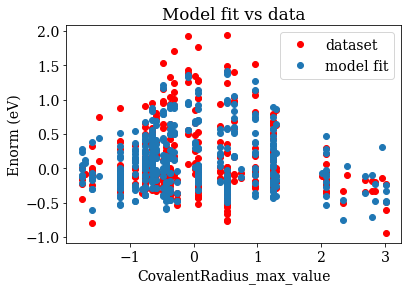

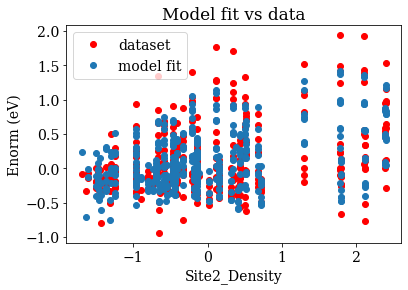

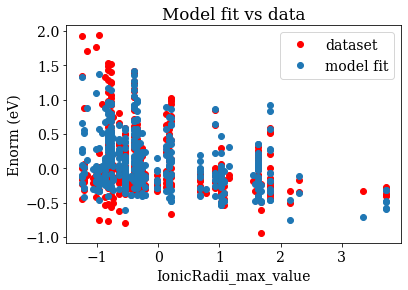

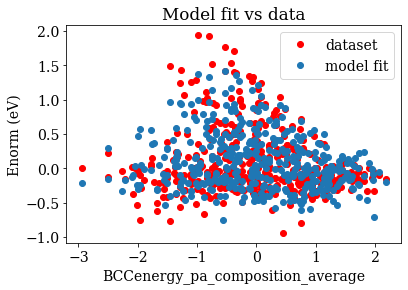

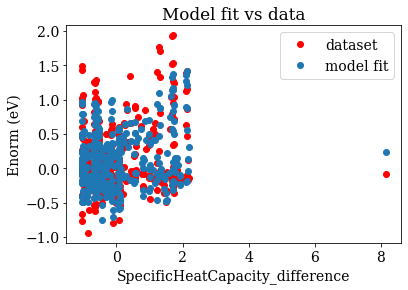

In [8]:
all_data=data.to_numpy()
ind_variable= [4,8,10,11,14,19,26]
dep_variable= all_data[:,2]

for i in ind_variable:
    plt.figure()
    plt.plot(all_data[:,i], dep_variable, 'ro', label='dataset')
    plt.plot(all_data[:,i], y_model_prediction,'o',label='model fit')
    plt.xlabel(data.columns[i])
    plt.ylabel('Enorm (eV)')
    plt.legend()
    plt.title('Model fit vs data')

In [9]:
r2=r2_score(y_data, y_model_prediction)
print('R2:', r2)

R2: 0.7545276409181378
